GitHub - https://github.com/nageswararao9012/A-Hands-On-Tutorial-on-Image-Classification-Using-CNN-and-VGG16-Transfer-Learning.git

IMPORT LIBRARIES

In [2]:
# Import required libraries for file handling, numerical operations and plotting
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Import Keras modules for building and training models
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
# Import evaluation tools
from sklearn.metrics import confusion_matrix, classification_report


UNZIP DATASET

In [3]:
# Path to downloaded dataset archive
ZIP_PATH = "Flowers Recognition Dataset.zip"   # change if needed
DATA_DIR = "flowers"

# Extract ZIP file into the directory
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

print("Main folders:", os.listdir(DATA_DIR))


Main folders: ['daisy', 'dandelion', 'flowers', 'label_map.pkl', 'rose', 'sunflower', 'test.csv', 'train.csv', 'tulip', 'validation.csv']


CLEAN STRUCTURE

In [6]:
# Select only valid class folders and ignore CSV / auxiliary files
import shutil

SOURCE_DIR = "flowers"          # your current extracted folder
CLEAN_DIR = "flowers_clean"     # new folder for training data

os.makedirs(CLEAN_DIR, exist_ok=True)

# Valid flower classes
valid_classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Copy class folders to clean directory
for folder in valid_classes:
    src = os.path.join(SOURCE_DIR, folder)
    dst = os.path.join(CLEAN_DIR, folder)
    
    if os.path.exists(dst):
        print(f"{folder} already exists")
    else:
        shutil.copytree(src, dst)
        print(f"Copied: {folder}")
        
# Confirm clean dataset content
print("Clean folders:", os.listdir(CLEAN_DIR))


Copied: daisy
Copied: dandelion
Copied: rose
Copied: sunflower
Copied: tulip
Clean folders: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
# Final dataset path used for model training
IMAGE_DIR = "flowers_clean"

print(os.listdir(IMAGE_DIR))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


VERIFY CLASS LABELS

In [9]:
print(train_data.class_indices)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [10]:
IMAGE_DIR = "flowers_clean"
print("Classes:", os.listdir(IMAGE_DIR))

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


SAMPLE IMAGE VISUALISATION

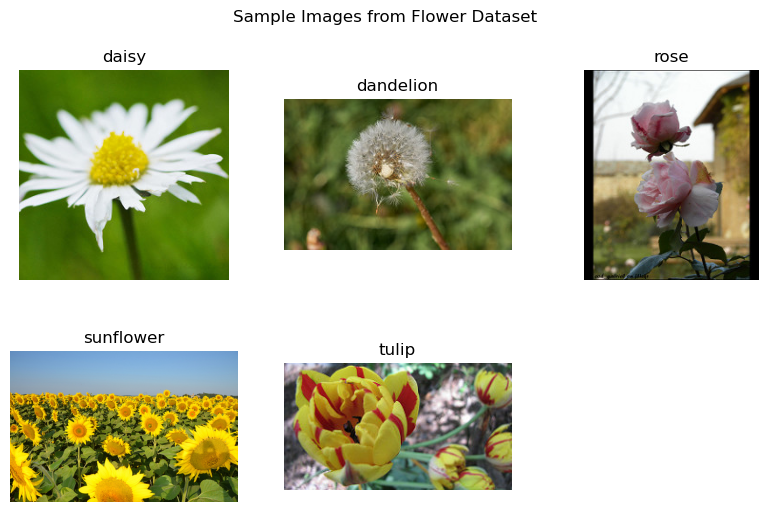

In [11]:
# Random images from each category
import random
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(10,6))

for i, cls in enumerate(os.listdir(IMAGE_DIR)):
    img_path = os.path.join(IMAGE_DIR, cls, random.choice(os.listdir(os.path.join(IMAGE_DIR, cls))))
    img = Image.open(img_path)
    
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Flower Dataset")
plt.show()


EDA (IMAGE COUNT PER CLASS)

In [12]:
import pandas as pd

counts = {}
for folder in os.listdir(IMAGE_DIR):
    counts[folder] = len(os.listdir(os.path.join(IMAGE_DIR, folder)))

df = pd.DataFrame.from_dict(counts, orient='index', columns=['Image_Count'])
df


,Image_Count
daisy,764
dandelion,1052
rose,784
sunflower,733
tulip,984


BAR CHART (DATA DISTRIBUTION)

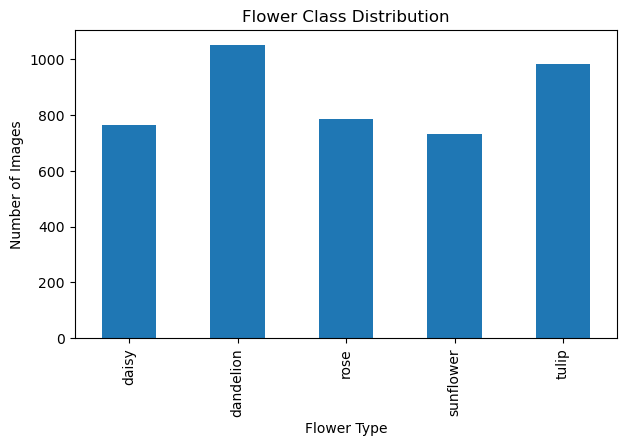

In [13]:
import matplotlib.pyplot as plt

df.plot(kind='bar', figsize=(7,4), legend=False)
plt.title("Flower Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Flower Type")
plt.show()


IMAGE PREPROCESSING & LOADING

In [14]:
# ImageDataGenerator for scaling and data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values
    validation_split=0.2, # 80% training, 20% validation
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(224,224), # Required input size for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# Print class label mapping
print("Class mapping:", train_data.class_indices)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Class mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


BASELINE CNN ARCHITECTURE

In [16]:
# Build CNN model from scratch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

cnn = Sequential([
    Input(shape=(224,224,3)), # Image input shape

    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(),

    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),               # Reduce overfitting
    Dense(train_data.num_classes,activation='softmax')
])

# Compile CNN model
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

TRAIN CNN

In [19]:
# Train baseline CNN model
cnn_history = cnn.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4674 - loss: 1.2383 - val_accuracy: 0.5465 - val_loss: 1.1085
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5883 - loss: 1.0468 - val_accuracy: 0.6047 - val_loss: 1.0133
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6399 - loss: 0.9545 - val_accuracy: 0.6453 - val_loss: 0.9195
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6701 - loss: 0.8331 - val_accuracy: 0.6686 - val_loss: 0.8264
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 108s 970ms/step - accuracy: 0.6621 - loss: 0.8213 - val_accuracy: 0.6919 - val_loss: 0.8389
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 101s 912ms/step - accuracy: 0.7126 - loss: 0.7312 - val_accuracy: 0.7174 - val_loss: 0.7893
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 104s 931ms/step - accuracy: 0.7073 - loss: 0.7407 - val_accuracy: 0.7000 - val_loss: 0.7822
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 103s 926ms/step - accuracy: 0.7275 - loss: 0.729

CNN ACCURACY & LOSS PLOTS

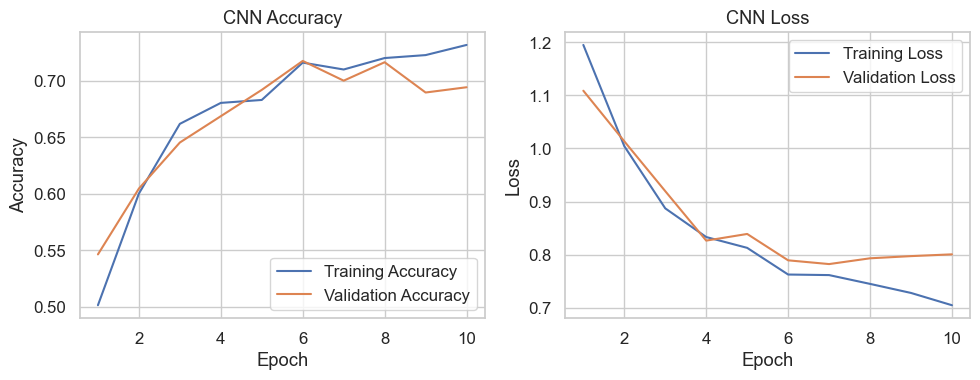

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot CNN training metrics
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10,4))

# Accuracy Plot
plt.subplot(1,2,1)
sns.lineplot(x=range(1, len(cnn_history.history['accuracy'])+1),
             y=cnn_history.history['accuracy'],
             label="Training Accuracy")

sns.lineplot(x=range(1, len(cnn_history.history['val_accuracy'])+1),
             y=cnn_history.history['val_accuracy'],
             label="Validation Accuracy")

plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
sns.lineplot(x=range(1, len(cnn_history.history['loss'])+1),
             y=cnn_history.history['loss'],
             label="Training Loss")

sns.lineplot(x=range(1, len(cnn_history.history['val_loss'])+1),
             y=cnn_history.history['val_loss'],
             label="Validation Loss")

plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


CNN CONFUSION MATRIX 

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step


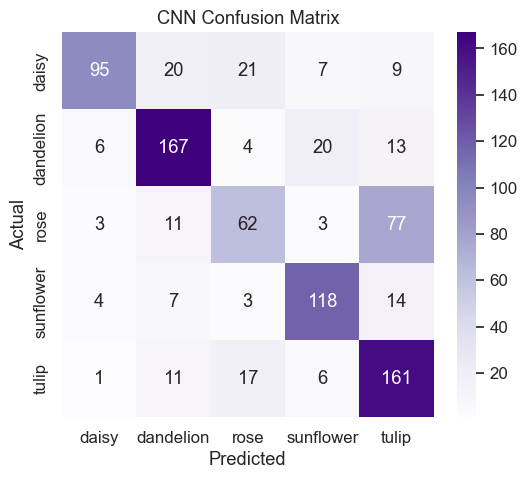

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for validation set
pred = np.argmax(cnn.predict(val_data), axis=1)
true = val_data.classes

# Compute confusion matrix
cm = confusion_matrix(true, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())

plt.title("CNN Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


CLASSIFICATION REPORT

In [22]:
from sklearn.metrics import classification_report

print(classification_report(true, pred, target_names=train_data.class_indices.keys()))


              precision    recall  f1-score   support

       daisy       0.87      0.62      0.73       152
   dandelion       0.77      0.80      0.78       210
        rose       0.58      0.40      0.47       156
   sunflower       0.77      0.81      0.79       146
       tulip       0.59      0.82      0.69       196

    accuracy                           0.70       860
   macro avg       0.72      0.69      0.69       860
weighted avg       0.71      0.70      0.70       860



LOAD VGG16 (FEATURE EXTRACTION)

In [23]:
# Load pretrained VGG16 without classifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze entire VGG16
base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

vgg_model = Model(base_model.input, output)

vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

TRAIN VGG16 (NO FINE-TUNING)

In [24]:
# Train frozen VGG16 model
vgg_history = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 564s 5s/step - accuracy: 0.4041 - loss: 1.4203 - val_accuracy: 0.6860 - val_loss: 0.9211
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 558s 5s/step - accuracy: 0.6482 - loss: 0.9291 - val_accuracy: 0.7419 - val_loss: 0.7523
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.6957 - loss: 0.7996 - val_accuracy: 0.7558 - val_loss: 0.6849
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.7436 - loss: 0.7177 - val_accuracy: 0.7826 - val_loss: 0.6524
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.7578 - loss: 0.6835 - val_accuracy: 0.7733 - val_loss: 0.6100
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7676 - loss: 0.6451 - val_accuracy: 0.7895 - val_loss: 0.5771
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.7684 - loss: 0.6242 - val_accuracy: 0.7756 - val_loss: 0.5865
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.7673 - loss: 0.6337 - val_accu

FINE-TUNING

In [25]:
# Unfreeze later layers only
base_model.trainable = True

for layer in base_model.layers[:12]:
    layer.trainable = False

# Compile with smaller learning rate
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train fine-tuned model
fine_tune_history = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - accuracy: 0.8210 - loss: 0.4819 - val_accuracy: 0.8442 - val_loss: 0.4263
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.8559 - loss: 0.3903 - val_accuracy: 0.8488 - val_loss: 0.4384
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 576s 5s/step - accuracy: 0.8889 - loss: 0.3059 - val_accuracy: 0.8651 - val_loss: 0.3741
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.9040 - loss: 0.2533 - val_accuracy: 0.8616 - val_loss: 0.4008
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 586s 5s/step - accuracy: 0.9141 - loss: 0.2264 - val_accuracy: 0.8849 - val_loss: 0.3395


ACCURACY & LOSS PLOTS

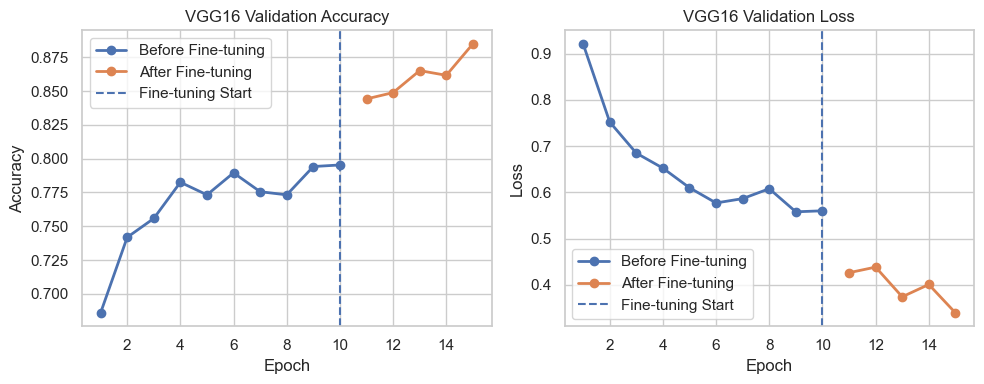

In [30]:
import matplotlib.pyplot as plt

epochs_vgg = list(range(1, len(vgg_history.history['val_accuracy']) + 1))
epochs_fine = list(range(epochs_vgg[-1] + 1,
                          epochs_vgg[-1] + 1 + len(fine_tune_history.history['val_accuracy'])))

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_vgg, vgg_history.history['val_accuracy'], marker='o', linewidth=2)
plt.plot(epochs_fine, fine_tune_history.history['val_accuracy'], marker='o', linewidth=2)
plt.axvline(x=epochs_vgg[-1], linestyle='--')
plt.title("VGG16 Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Before Fine-tuning", "After Fine-tuning", "Fine-tuning Start"])
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_vgg, vgg_history.history['val_loss'], marker='o', linewidth=2)
plt.plot(epochs_fine, fine_tune_history.history['val_loss'], marker='o', linewidth=2)
plt.axvline(x=epochs_vgg[-1], linestyle='--')
plt.title("VGG16 Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Before Fine-tuning", "After Fine-tuning", "Fine-tuning Start"])
plt.grid(True)

plt.tight_layout()
plt.show()


CONFUSION MATRIX (VGG16)

27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step


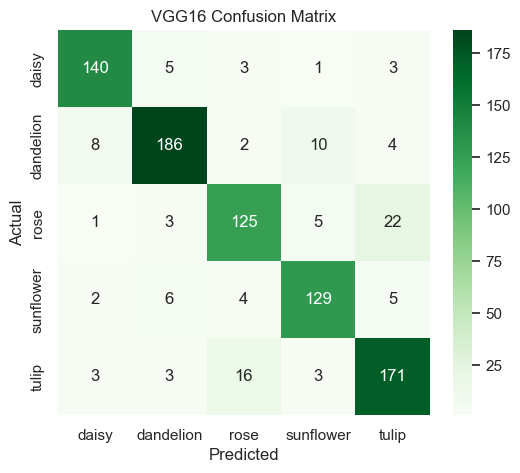

              precision    recall  f1-score   support

       daisy       0.91      0.92      0.92       152
   dandelion       0.92      0.89      0.90       210
        rose       0.83      0.80      0.82       156
   sunflower       0.87      0.88      0.88       146
       tulip       0.83      0.87      0.85       196

    accuracy                           0.87       860
   macro avg       0.87      0.87      0.87       860
weighted avg       0.87      0.87      0.87       860



In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Final evaluation after fine-tuning
vgg_preds = np.argmax(vgg_model.predict(val_data), axis=1)
true = val_data.classes

cm_vgg = confusion_matrix(true, vgg_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap="Greens",
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())

plt.title("VGG16 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(classification_report(true, vgg_preds, target_names=train_data.class_indices.keys()))


Prediction Visualization

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(model, dataset, title, class_names):
    plt.figure(figsize=(16,6))
    
    images, labels = next(iter(dataset))
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    # Convert one-hot labels safely
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")

        true = class_names[labels[i]]
        pred = class_names[pred_labels[i]]
        color = "green" if true == pred else "red"

        plt.title(f"Pred: {pred}\nActual: {true}", color=color, fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.show()


In [48]:
# Create class name list from data generator
class_names = list(train_data.class_indices.keys())
class_names


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

CNN PREDICTIONS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


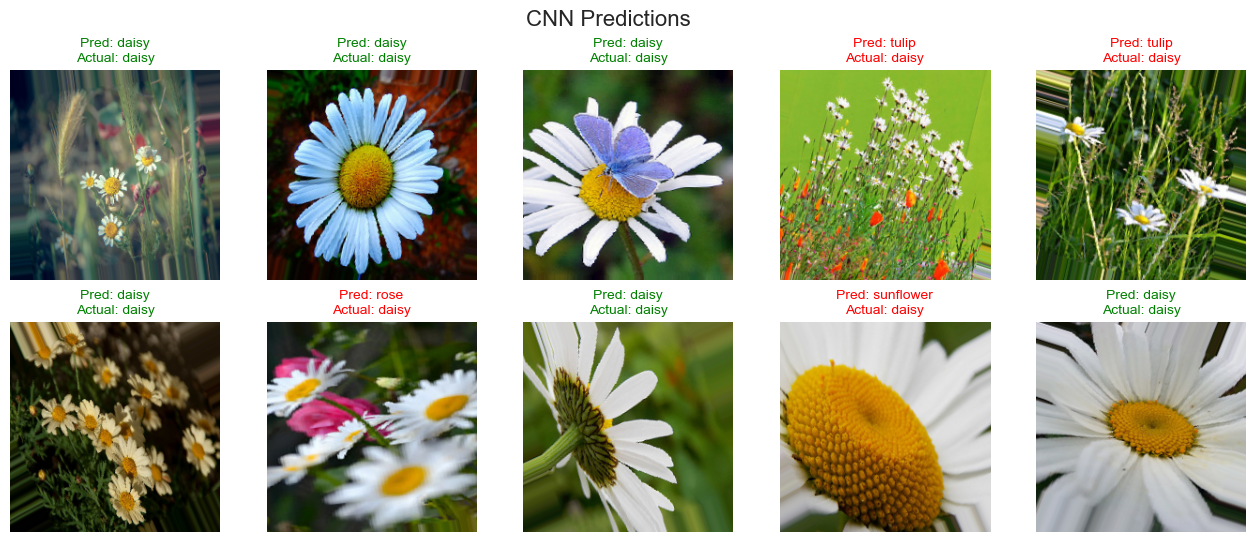

In [49]:
show_predictions(
    cnn,
    val_data,
    title="CNN Predictions",
    class_names=class_names
)

VGG16 PREDICTIONS (FINE-TUNED)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


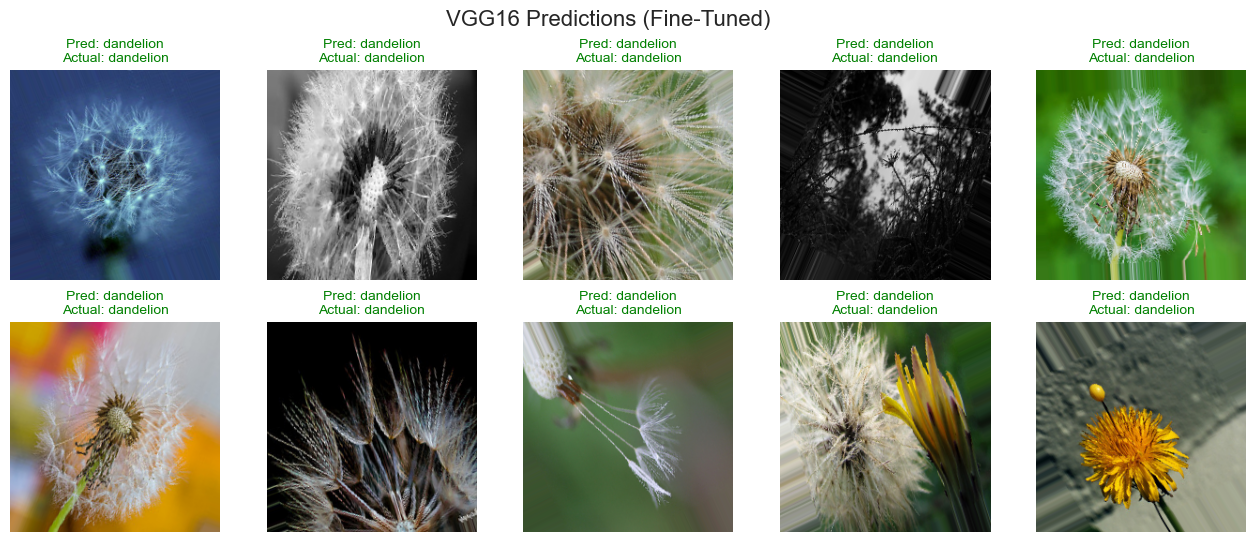

In [57]:
show_predictions(
    vgg_model,
    val_data,
    title="VGG16 Predictions (Fine-Tuned)",
    class_names=class_names
)
